<a href="https://colab.research.google.com/github/RSNA/AI-Deep-Learning-Lab-2024/blob/main/sessions/diy-dl/RSNA24_DLL_DIY_DL_answer_key.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! wget -qO data.zip https://github.com/paras42/Hello_World_Deep_Learning/blob/master/Open_I_abd_vs_CXRs.zip?raw=true
! unzip -qq data.zip
! rm data.zip

In [ ]:
! mv Open_I_abd_vs_CXRs/ data/

In [ ]:
data_dir = './data'

! mv {data_dir}/TRAIN/openI_CXR {data_dir}/TRAIN/chest
! mv {data_dir}/TRAIN/openI_abd_xray {data_dir}/TRAIN/abd
! mv {data_dir}/VAL/openI_CXR {data_dir}/VAL/chest
! mv {data_dir}/VAL/openI_abd_xray {data_dir}/VAL/abd

In [ ]:
# prompt: create torchvision image folder datasets and pytorch dataloaders for the TRAIN and VAL subfolders of data_dir

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define transforms for the images (you can customize these)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a common size
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet statistics
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Create ImageFolder datasets for train and validation sets
train_dataset = ImageFolder(root=f'{data_dir}/TRAIN', transform=train_transform)
val_dataset = ImageFolder(root=f'{data_dir}/VAL', transform=val_transform)

# Create data loaders for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Adjust batch size as needed
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# prompt: write a training loop to train a resnet18 for 3 epochs

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the final layer to match the number of classes (2 in this case: abd and chest)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Move the model to the device (GPU or CPU)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 10 == 9:  # Print every 10 mini-batches
            print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 10:.4f}")
            running_loss = 0.0

    # Validation loop (optional, but recommended)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Epoch: {epoch + 1}, Validation Accuracy: {(100 * correct / total):.2f}%")

# Save the trained model
torch.save(model.state_dict(), "resnet18_abd_chest.pth")

print("Training finished.")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]


Epoch: 1, Validation Accuracy: 100.00%
Epoch: 2, Validation Accuracy: 100.00%
Epoch: 3, Validation Accuracy: 100.00%
Training finished.


In [ ]:
# prompt: write a predict function for the trained model that takes a path to an image file as input

from PIL import Image

def predict(image_path):
  """
  Predicts the class of an image using the trained model.

  Args:
    image_path: Path to the image file.

  Returns:
    A tuple containing the predicted class label and the corresponding probability.
  """
  # Load and preprocess the image
  image = Image.open(image_path).convert("RGB")
  image = val_transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

  # Set the model to evaluation mode
  model.eval()

  # Make a prediction
  with torch.no_grad():
    outputs = model(image)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    _, predicted_class = torch.max(outputs, 1)

  # Get the class label and probability
  class_labels = train_dataset.classes
  predicted_label = class_labels[predicted_class.item()]
  predicted_probability = probabilities[0, predicted_class.item()].item()

  return predicted_label, predicted_probability


Predicted Label: abd, Probability: 1.0000


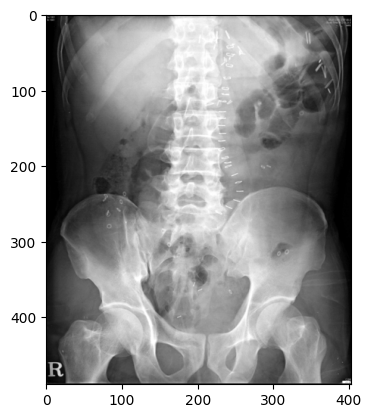

In [ ]:
import os
import matplotlib.pyplot as plt

file_path = os.path.join(data_dir, 'TEST', 'abd2.png')
pred_label, pred_prob = predict(file_path)
print(f"Predicted Label: {pred_label}, Probability: {pred_prob:.4f}")
plt.imshow(Image.open(file_path));

Predicted Label: chest, Probability: 0.9998


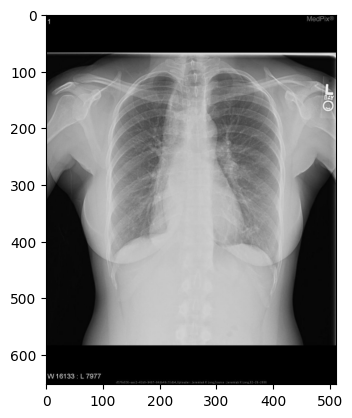

In [ ]:
file_path = os.path.join(data_dir, 'TEST', 'chest2.png')
pred_label, pred_prob = predict(file_path)
print(f"Predicted Label: {pred_label}, Probability: {pred_prob:.4f}")
plt.imshow(Image.open(file_path));